In [1]:
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from transformers import pipeline

d:\News_Exploration\timesofindia\lib\site-packages\torchaudio\backend\utils.py:67: UserWarning: No audio backend is available.
  warnings.warn('No audio backend is available.')


In [7]:
data = pd.read_json('india-news-headlines-geoparsed.json')
data.head()

,date,headline_category,title,geoparsed
0,2001-01-02,unknown,Status quo will not be disturbed at Ayodhya; s...,"{'milliseconds': 2237, 'language': 'EN', 'vers..."
1,2001-01-02,unknown,Petition over ministers' assets dismissed,"{'milliseconds': 2, 'language': 'EN', 'version..."
2,2001-01-02,unknown,Bomb hoax triggers panic in Canara Bank,"{'milliseconds': 1, 'language': 'EN', 'version..."
3,2001-01-02,unknown,Consul is back from month-long leave,"{'milliseconds': 2, 'language': 'EN', 'version..."
4,2001-01-02,unknown,Redemption night; amid some rock,"{'milliseconds': 1, 'language': 'EN', 'version..."


In [8]:
data['date']= pd.to_datetime(data['date'])

In [9]:
print('Number of Articles for all dates: {}'.format(data.shape[0]))

Number of Articles for all dates: 3424067


In [10]:
# Only consider data from year 2011 onwards (acled records from there only)

data = data[data['date'] >= datetime.strptime('2011-01-01', '%Y-%m-%d')]
print('Number of Articles after year 2011: {}'.format(data.shape[0]))

Number of Articles after year 2011: 2389855


In [12]:
data.tail()

,date,headline_category,title,geoparsed
3424062,2020-12-31,city.nagpur,No Covid casualty in 7 dists of Vidarbha; reco...,"{'milliseconds': 1, 'language': 'EN', 'version..."
3424063,2020-12-31,city.ranchi,Cops across police stns in state to soon get w...,"{'milliseconds': 0, 'language': 'EN', 'version..."
3424064,2020-12-31,city.kolkata,Cops rescue trafficked girls from Bihar,"{'milliseconds': 1, 'language': 'EN', 'version..."
3424065,2020-12-31,city.bengaluru,25% of four-wheelers in Karnataka yet to get F...,"{'milliseconds': 1, 'language': 'EN', 'version..."
3424066,2020-12-31,entertainment.bengali.movies.news,Celebs plan to party safely and responsibly on...,"{'milliseconds': 1, 'language': 'EN', 'version..."


In [11]:
data.head()

,date,headline_category,title,geoparsed
1034212,2011-01-01,speak-out,Do you agree that the increase in fine from Rs...,"{'milliseconds': 2, 'language': 'EN', 'version..."
1034213,2011-01-01,unknown,Beckham set for England return with Spurs,"{'milliseconds': 1, 'language': 'EN', 'version..."
1034214,2011-01-01,unknown,India ready to make history: Dhoni,"{'milliseconds': 1, 'language': 'EN', 'version..."
1034215,2011-01-01,tech,7 Technologies to look for in 2011,"{'milliseconds': 0, 'language': 'EN', 'version..."
1034216,2011-01-01,unknown,Home; car loans get costlier in New Year,"{'milliseconds': 1, 'language': 'EN', 'version..."


# Processing Data

In [13]:
# For list of cities, take note of 'name', 'stateCode', 'id'
# For list of states, take note of 'name', 'stateCode', 'id'
# For list of countries, take note of 'name', 'countryCode'

## Cleaning dataset
- Extract out info from cliff-clavin output

In [13]:
cities_list, states_list, countries_list, country_name, country_code = [], [], [], [], []
for x in tqdm(data['geoparsed']):
    if x['results']['places']['focus']:
        cities_list.append(x['results']['places']['focus']['cities'])
        states_list.append(x['results']['places']['focus']['states'])
        countries_list.append(x['results']['places']['focus']['countries'])
        tmp_country_name, tmp_country_code = [], []
        for country in x['results']['places']['focus']['countries']:
            tmp_country_name.append(country['name'])
            tmp_country_code.append(country['countryCode'])
        country_name.append(tmp_country_name)
        country_code.append(tmp_country_code)
    else:
        cities_list.append(None)
        states_list.append(None)
        countries_list.append(None)
        country_name.append(None)
        country_code.append(None)

100%|██████████| 2389855/2389855 [00:02<00:00, 976586.96it/s]


In [14]:
data['cities_list'] = cities_list
data['states_list'] = states_list
data['countries_list'] = countries_list
data['country_name'] = country_name
data['country_code'] = country_code

In [15]:
# Check for number of rows with no countries assosociated: 68043 rows
no_country = data['countries_list'].isnull().sum()
old_rows = data.shape[0]
print("Number of articles with no countries detected: {}".format(no_country))
print("Percentage of articles with no countries detected: {:.2f}%".format(no_country/old_rows * 100))

Number of articles with no countries detected: 1865808
Percentage of articles with no countries detected: 78.07%


In [16]:
# Drop rows with no country tagged; make sure no data lost
data = data.dropna(axis = 0, subset = ['countries_list'])
print(data.shape[0] == old_rows - no_country)
print("Number of articles left with countries detected: {}".format(data.shape[0]))

True
Number of articles left with countries detected: 524047


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524047 entries, 1034212 to 3424065
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               524047 non-null  datetime64[ns]
 1   headline_category  524047 non-null  object        
 2   title              524047 non-null  object        
 3   geoparsed          524047 non-null  object        
 4   cities_list        524047 non-null  object        
 5   states_list        524047 non-null  object        
 6   countries_list     524047 non-null  object        
 7   country_name       524047 non-null  object        
 8   country_code       524047 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 40.0+ MB


In [18]:
data.tail()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code
3424057,2020-12-31,city.delhi,New policy: Transplant 80% of trees affected b...,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",[Republic of India],[IN]
3424058,2020-12-31,city.delhi,Cleanest in 3 yrs: Delhi had 192 'good air' da...,"{'milliseconds': 2, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",[Republic of India],[IN]
3424062,2020-12-31,city.nagpur,No Covid casualty in 7 dists of Vidarbha; reco...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",[Republic of India],[IN]
3424064,2020-12-31,city.kolkata,Cops rescue trafficked girls from Bihar,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",[Republic of India],[IN]
3424065,2020-12-31,city.bengaluru,25% of four-wheelers in Karnataka yet to get F...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",[Republic of India],[IN]


In [19]:
# For rows with more than 1 country, duplicate them such that each row only contains one country
data.rename(columns={'country_name': 'x', 'country_code': 'y'}, inplace=True)
data = data.explode(list('xy'))
data.rename(columns={'x': 'country_name', 'y': 'country_code'}, inplace=True)
data.tail()


,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code
3424057,2020-12-31,city.delhi,New policy: Transplant 80% of trees affected b...,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
3424058,2020-12-31,city.delhi,Cleanest in 3 yrs: Delhi had 192 'good air' da...,"{'milliseconds': 2, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
3424062,2020-12-31,city.nagpur,No Covid casualty in 7 dists of Vidarbha; reco...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
3424064,2020-12-31,city.kolkata,Cops rescue trafficked girls from Bihar,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
3424065,2020-12-31,city.bengaluru,25% of four-wheelers in Karnataka yet to get F...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 551058 entries, 1034212 to 3424065
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               551058 non-null  datetime64[ns]
 1   headline_category  551058 non-null  object        
 2   title              551058 non-null  object        
 3   geoparsed          551058 non-null  object        
 4   cities_list        551058 non-null  object        
 5   states_list        551058 non-null  object        
 6   countries_list     551058 non-null  object        
 7   country_name       548352 non-null  object        
 8   country_code       548352 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 42.0+ MB


In [21]:
country_count = data['country_code'].value_counts(dropna=False)
country_count.to_json('India News Total Country Counts.json')

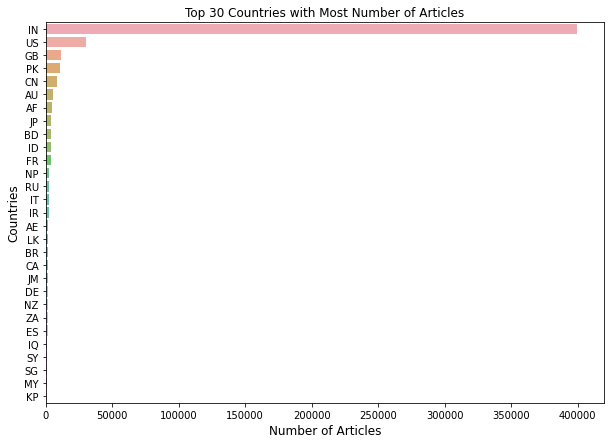

In [22]:
country_count = country_count[:30,]
plt.figure(figsize=(10,7))
sns.barplot(y = country_count.index, x= country_count.values, alpha=0.8)
plt.title('Top 30 Countries with Most Number of Articles')
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Countries', fontsize=12)
# plt.grid()
plt.show()

# Splitting into buckets for countries of interest

In [23]:
countries_of_interest = ['IN', 'PK', 'BD']

for country in countries_of_interest:
    tmp = data[data['country_code'] == country]
    tmp.to_json('india-news-headlines_' + country + '_total.json')
    print("Total number of articles for {}: {}".format(country, tmp.shape[0]))


Total number of articles for IN: 399765
Total number of articles for PK: 10783
Total number of articles for BD: 4006


## India

### Categorise News Articles

In [2]:
india_total = pd.read_json('india-news-headlines_IN_total.json').reset_index(drop = True)

In [4]:
india_total.head()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code
0,2011-01-01,speak-out,Do you agree that the increase in fine from Rs...,"{'milliseconds': 2, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
1,2011-01-01,unknown,India ready to make history: Dhoni,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
2,2011-01-01,unknown,All-religion centre planned in Bangalore,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
3,2011-01-01,world.pakistan,India; Pakistan exchange lists of nuclear inst...,"{'milliseconds': 2, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN
4,2011-01-01,unknown,India eye historic series triumph in SA,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN


In [5]:
india_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 399765 entries, 0 to 399764
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               399765 non-null  datetime64[ns]
 1   headline_category  399765 non-null  object        
 2   title              399765 non-null  object        
 3   geoparsed          399765 non-null  object        
 4   cities_list        399765 non-null  object        
 5   states_list        399765 non-null  object        
 6   countries_list     399765 non-null  object        
 7   country_name       399765 non-null  object        
 8   country_code       399765 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 27.4+ MB


In [6]:
india_total['title']

0         Do you agree that the increase in fine from Rs...
1                        India ready to make history: Dhoni
2                  All-religion centre planned in Bangalore
3         India; Pakistan exchange lists of nuclear inst...
4                   India eye historic series triumph in SA
                                ...                        
399760    New policy: Transplant 80% of trees affected b...
399761    Cleanest in 3 yrs: Delhi had 192 'good air' da...
399762    No Covid casualty in 7 dists of Vidarbha; reco...
399763              Cops rescue trafficked girls from Bihar
399764    25% of four-wheelers in Karnataka yet to get F...
Name: title, Length: 399765, dtype: object

In [4]:
classifier_pipe = pipeline("text-classification", model = 'mrm8488/bert-mini-finetuned-age_news-classification', tokenizer='mrm8488/bert-mini-finetuned-age_news-classification',device = 0)

In [5]:
news_tag, news_tag_confid = [], []

for title in tqdm(india_total['title']):
    result = classifier_pipe(title)[0]
    news_tag.append(result['label'])
    news_tag_confid.append(result['score'])

india_total['news tag'] = news_tag
india_total['news tag confidence'] = news_tag_confid

100%|██████████| 399765/399765 [24:30<00:00, 271.92it/s]


In [6]:
india_total['news tag'].value_counts()

World       298086
Business     55810
Sci/Tech     28392
Sports       17477
Name: news tag, dtype: int64

In [7]:
focus_tags = india_total['news tag'].value_counts()['World'] + india_total['news tag'].value_counts()['Business']
print("Number of articles with tags of interest: {}".format(focus_tags))

Number of articles with tags of interest: 353896


Text(0.5, 1.0, 'Breakdown of Articles about India')

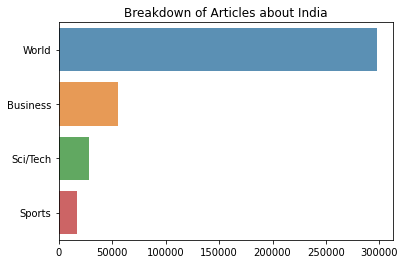

In [8]:
# india_total['news tag'].value_counts().plot(kind = 'bar')
sns.barplot(y = india_total['news tag'].value_counts().index, x = india_total['news tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Articles about India')

In [9]:
# Drop Sci/Tech and Sports tagged articles

# india_total = india_total[(india_total['news tag'] == 'World') | (india_total['news tag'] == 'Business')]
# print(india_total.shape[0] == focus_tags)

### Sentiment Analysis

In [10]:
sentiment_analyser = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english",device = 0)

Downloading: 100%|██████████| 687/687 [00:00<00:00, 304kB/s]
Downloading: 100%|██████████| 1.42G/1.42G [02:14<00:00, 10.5MB/s]
Downloading: 100%|██████████| 256/256 [00:00<00:00, 128kB/s]
Downloading: 100%|██████████| 798k/798k [00:00<00:00, 1.10MB/s]
Downloading: 100%|██████████| 456k/456k [00:00<00:00, 1.62MB/s]
Downloading: 100%|██████████| 150/150 [00:00<00:00, 65.8kB/s]


In [11]:
SA_tag, SA_tag_confid = [], []

for title in tqdm(india_total['title']):
    result = sentiment_analyser(title)[0]
    SA_tag.append(result['label'])
    SA_tag_confid.append(result['score'])

india_total['SA tag'] = SA_tag
india_total['SA tag confidence'] = SA_tag_confid

100%|██████████| 399765/399765 [1:50:44<00:00, 60.17it/s]


In [12]:
india_total['SA tag'].value_counts()

NEGATIVE    200925
POSITIVE    198840
Name: SA tag, dtype: int64

Text(0.5, 1.0, 'Breakdown of Sentiment of All Articles about India')

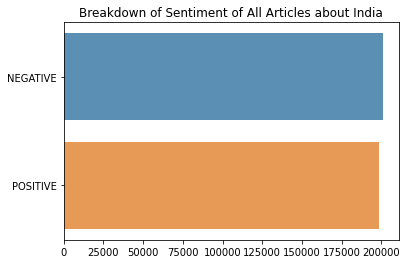

In [13]:
sns.barplot(y = india_total['SA tag'].value_counts().index, x = india_total['SA tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Sentiment of All Articles about India')

In [14]:
# sns.barplot(y = india_total['SA tag'].value_counts().index, x = india_total['SA tag'].value_counts().values, alpha=0.8)
# plt.title('Breakdown of Sentiment of World/Business Articles about India')

In [15]:
india_total.head()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code,news tag,news tag confidence,SA tag,SA tag confidence
0,2011-01-01,speak-out,Do you agree that the increase in fine from Rs...,"{'milliseconds': 2, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,Business,0.803377,NEGATIVE,0.969205
1,2011-01-01,unknown,India ready to make history: Dhoni,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.994686,POSITIVE,0.998286
2,2011-01-01,unknown,All-religion centre planned in Bangalore,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPLA', 'stateGeo...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.986057,POSITIVE,0.996107
3,2011-01-01,world.pakistan,India; Pakistan exchange lists of nuclear inst...,"{'milliseconds': 2, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.991070,POSITIVE,0.992906
4,2011-01-01,unknown,India eye historic series triumph in SA,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Republic of India,IN,World,0.991931,POSITIVE,0.998448


In [16]:
india_total.to_json('india-news-headlines_IN_features_extracted.json')

## Repeat for Pakistan

### Categorise News Articles

In [17]:
pakistan_total = pd.read_json('india-news-headlines_PK_total.json').reset_index(drop = True)

In [18]:
pakistan_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10783 entries, 0 to 10782
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               10783 non-null  datetime64[ns]
 1   headline_category  10783 non-null  object        
 2   title              10783 non-null  object        
 3   geoparsed          10783 non-null  object        
 4   cities_list        10783 non-null  object        
 5   states_list        10783 non-null  object        
 6   countries_list     10783 non-null  object        
 7   country_name       10783 non-null  object        
 8   country_code       10783 non-null  object        
dtypes: datetime64[ns](1), object(8)
memory usage: 758.3+ KB


In [19]:
news_tag, news_tag_confid = [], []

for title in tqdm(pakistan_total['title']):
    result = classifier_pipe(title)[0]
    news_tag.append(result['label'])
    news_tag_confid.append(result['score'])

pakistan_total['news tag'] = news_tag
pakistan_total['news tag confidence'] = news_tag_confid

100%|██████████| 10783/10783 [00:35<00:00, 301.56it/s]


In [20]:
pakistan_total['news tag'].value_counts()

World       9790
Business     404
Sci/Tech     301
Sports       288
Name: news tag, dtype: int64

In [21]:
focus_tags = pakistan_total['news tag'].value_counts()['World'] + pakistan_total['news tag'].value_counts()['Business']
print("Number of articles with tags of interest: {}".format(focus_tags))

Number of articles with tags of interest: 10194


Text(0.5, 1.0, 'Breakdown of Articles about Pakistan')

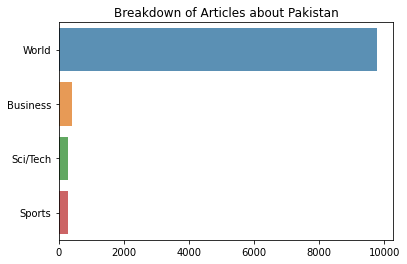

In [22]:
sns.barplot(y = pakistan_total['news tag'].value_counts().index, x = pakistan_total['news tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Articles about Pakistan')

In [23]:
# Drop Sci/Tech and Sports tagged articles

# pakistan_total = pakistan_total[(pakistan_total['news tag'] == 'World') | (pakistan_total['news tag'] == 'Business')]
# print(pakistan_total.shape[0] == focus_tags)

### Sentiment Analysis

In [24]:
SA_tag, SA_tag_confid = [], []

for title in tqdm(pakistan_total['title']):
    result = sentiment_analyser(title)[0]
    SA_tag.append(result['label'])
    SA_tag_confid.append(result['score'])

pakistan_total['SA tag'] = SA_tag
pakistan_total['SA tag confidence'] = SA_tag_confid

100%|██████████| 10783/10783 [02:57<00:00, 60.72it/s]


In [25]:
pakistan_total['SA tag'].value_counts()

NEGATIVE    6220
POSITIVE    4563
Name: SA tag, dtype: int64

Text(0.5, 1.0, 'Breakdown of Sentiment of all Articles about Pakistan')

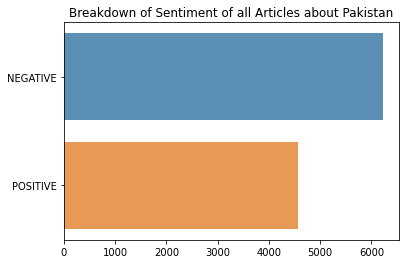

In [26]:
sns.barplot(y = pakistan_total['SA tag'].value_counts().index, x = pakistan_total['SA tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Sentiment of all Articles about Pakistan')

In [27]:
# sns.barplot(y = pakistan_total['SA tag'].value_counts().index, x = pakistan_total['SA tag'].value_counts().values, alpha=0.8)
# plt.title('Breakdown of Sentiment of World/Business Articles about Pakistan')

In [28]:
pakistan_total.head()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code,news tag,news tag confidence,SA tag,SA tag confidence
0,2011-01-01,world.pakistan,India; Pakistan exchange lists of nuclear inst...,"{'milliseconds': 2, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK,World,0.991070,POSITIVE,0.992906
1,2011-01-01,unknown,India; Pakistan exchange list of nuclear insta...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK,World,0.990780,POSITIVE,0.991225
2,2011-01-01,india,India; Pakistan exchange list of nuclear insta...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK,World,0.990780,POSITIVE,0.991225
3,2011-01-02,unknown,Pak PM Gilani says; Pakistan and India cannot ...,"{'milliseconds': 2, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK,World,0.996570,POSITIVE,0.979854
4,2011-01-02,sports.icc-world-cup-2015,Pakistan cricket will taste success in 2011: I...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Islamic Republic of Pakistan,PK,World,0.990836,POSITIVE,0.998248


In [29]:
pakistan_total.to_json('india-news-headlines_PK_features_extracted.json')

## Repeat for Bangladesh

### Categorise News Articles

In [30]:
bangladesh_total = pd.read_json('india-news-headlines_BD_total.json').reset_index(drop = True)

In [31]:
bangladesh_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4006 entries, 0 to 4005
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   date               4006 non-null   datetime64[ns]
 1   headline_category  4006 non-null   object        
 2   title              4006 non-null   object        
 3   geoparsed          4006 non-null   object        
 4   cities_list        4006 non-null   object        
 5   states_list        4006 non-null   object        
 6   countries_list     4006 non-null   object        
 7   country_name       4006 non-null   object        
 8   country_code       4006 non-null   object        
dtypes: datetime64[ns](1), object(8)
memory usage: 281.8+ KB


In [32]:
news_tag, news_tag_confid = [], []

for title in tqdm(bangladesh_total['title']):
    result = classifier_pipe(title)[0]
    news_tag.append(result['label'])
    news_tag_confid.append(result['score'])

bangladesh_total['news tag'] = news_tag
bangladesh_total['news tag confidence'] = news_tag_confid

100%|██████████| 4006/4006 [00:13<00:00, 307.56it/s]


In [33]:
bangladesh_total['news tag'].value_counts()

World       3279
Business     385
Sports       173
Sci/Tech     169
Name: news tag, dtype: int64

In [34]:
focus_tags = bangladesh_total['news tag'].value_counts()['World'] + bangladesh_total['news tag'].value_counts()['Business']
print("Number of articles with tags of interest: {}".format(focus_tags))

Number of articles with tags of interest: 3664


Text(0.5, 1.0, 'Breakdown of Articles about Bangladesh')

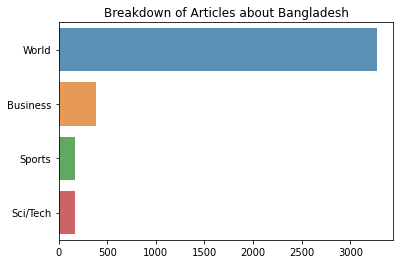

In [35]:
sns.barplot(y = bangladesh_total['news tag'].value_counts().index, x = bangladesh_total['news tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Articles about Bangladesh')

In [36]:
# Drop Sci/Tech and Sports tagged articles

# bangladesh_total = bangladesh_total[(bangladesh_total['news tag'] == 'World') | (bangladesh_total['news tag'] == 'Business')]
# print(bangladesh_total.shape[0] == focus_tags)

### Sentiment Analysis

In [37]:
SA_tag, SA_tag_confid = [], []

for title in tqdm(bangladesh_total['title']):
    result = sentiment_analyser(title)[0]
    SA_tag.append(result['label'])
    SA_tag_confid.append(result['score'])

bangladesh_total['SA tag'] = SA_tag
bangladesh_total['SA tag confidence'] = SA_tag_confid

100%|██████████| 4006/4006 [01:06<00:00, 60.69it/s]


In [38]:
bangladesh_total['SA tag'].value_counts()

NEGATIVE    2083
POSITIVE    1923
Name: SA tag, dtype: int64

Text(0.5, 1.0, 'Breakdown of Sentiment of all Articles about Bangladesh')

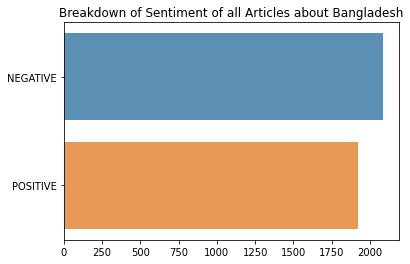

In [39]:
sns.barplot(y = bangladesh_total['SA tag'].value_counts().index, x = bangladesh_total['SA tag'].value_counts().values, alpha=0.8)
plt.title('Breakdown of Sentiment of all Articles about Bangladesh')

In [40]:
bangladesh_total.head()

,date,headline_category,title,geoparsed,cities_list,states_list,countries_list,country_name,country_code,news tag,news tag confidence,SA tag,SA tag confidence
0,2011-01-02,city.varanasi,Vocational course at madarsa,"{'milliseconds': 1, 'language': 'EN', 'version...",[],"[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Bangladesh,BD,World,0.623897,POSITIVE,0.994792
1,2011-01-06,city.allahabad,Youth murdered in Nawabganj,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Bangladesh,BD,World,0.995847,NEGATIVE,0.995906
2,2011-01-10,unknown,Bangladesh police; investors clash as stocks p...,"{'milliseconds': 1, 'language': 'EN', 'version...",[],[],"[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Bangladesh,BD,Business,0.967927,NEGATIVE,0.998615
3,2011-01-11,city.vadodara,There's much more to Pratapnagar Railway Herit...,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Bangladesh,BD,World,0.962403,POSITIVE,0.997639
4,2011-01-12,first-look,Run Bhola Run,"{'milliseconds': 1, 'language': 'EN', 'version...","[{'score': 1, 'featureCode': 'PPL', 'stateGeoN...","[{'score': 1, 'featureCode': 'ADM1', 'stateGeo...","[{'score': 1, 'featureCode': 'PCLI', 'stateGeo...",Bangladesh,BD,World,0.888429,POSITIVE,0.990898


In [41]:
bangladesh_total.to_json('india-news-headlines_BD_features_extracted.json')